<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg"  width=300, align="right">
<br>
<br>
<br>
<br>
<br>

# **Template para o Colab do Projeto Semestral**
---

Atenção, podem ser que nem todas as tarefas sejam executadas no Colab (a aplicação por exemplo, pode estar hospedada no streamlit cloud). Mas a maior parte pode estar aqui ou ao menos indicada e comentada.


Além disso a entrega deve incluir:

1. **Um GitHub público do projeto**
2. **Código completo e executável em um notebook Python (este template)**
3. **Uma aplicação streamlit para consumo do modelo**
4. **Um texto/artigo do projeto**
5. **Um vídeo (link YouTube ou outro) de no máximo 3min de apresentação do projeto**

Um **`readme.md`** no GitHub público do projeto deve indicar (um índice) cada uma dessas entregas.








In [ ]:
#@title **Identificação do Grupo**

#@markdown Integrantes do Grupo, nome completo em orgem alfabética (*informe \<RA\>,\<nome\>*)
Aluno1 = '10297494 Giovana Ribeiro de Franciso' #@param {type:"string"}
Aluno2 = '10402951, Leila Akina Ino' #@param {type:"string"}
Aluno3 = '10400969, Leticia Moraes Gutierrez de Oliveira' #@param {type:"string"}


In [ ]:
#@title Assinale aqui a sua opção de Projeto
Projeto = "IA Aplicada a Imagens: Uso de Modelos de Redes Neurais" #@param ["IA Aplicada a Imagens: Uso de Modelos de Redes Neurais", "IA Aplicada a Documentos: Uso de Grandes Modelos de Linguagem Abertos"]

# **Resumo**

Apresente um "abstract" do seu projeto.

1. Objetivo do projeto
2. Fontes dos dados e dados originais (coletados)
3. Ferramentas/pacotes de IA a serem utilizados para a construção da solução
4. Um prévia dos resultados.

Este projeto tem como objetivo aplicar técnicas de Visão Computacional utilizando Deep Learning para classificar imagens de gatos em quatro raças distintas: Maine Coon, Sphynx, Persa e Siamês. A classificação é realizada por um modelo baseado na arquitetura EfficientNet, treinado com um conjunto de dados organizado em pastas separadas para cada raça, utilizando imagens reais de gatos.

As imagens foram coletadas e organizadas manualmente pelo grupo, e estão disponíveis em um repositório no GitHub.

O conjunto foi dividido em duas pastas principais:

treino/: usado para treinar o modelo

teste/: usado para avaliação do desempenho final
Cada uma contém subpastas com imagens das quatro raças.

Para o desenvolvimento da solução, foram utilizados os seguintes pacotes e frameworks:

- Python

- TensorFlow / Keras (para criação e treinamento do modelo)

- EfficientNet (com pesos pré-treinados no ImageNet)

- scikit-learn (para avaliação)

- Matplotlib / Seaborn (para visualização)

- Streamlit (para criar a aplicação web de classificação de imagens)

Como resultado parcial, o modelo não atinge uma acurácia muito boa, devido a poucas imagens no dataset durante a validação, no entando, é capaz de prever com boa confiabilidade a raça de gatos a partir de novas imagens. A aplicação final, desenvolvida com Streamlit, permite que o usuário envie uma imagem e receba a predição da raça com a respectiva confiança do modelo.

# **Apresentação dos dados**

[Github do Projeto](https://github.com/LeticiaMoraesG/Projeto_gatos/tree/main)

# Instalações das bibliotecas e clonamento do git

> Aqui nós estamos fazendo os intalamentos das bibliotecas e a clonagem do github ao colab e as importações necessárias


In [ ]:
!pip install tensorflow
!pip install pillow
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install pandas
!pip install numpy
!git clone https://github.com/LeticiaMoraesG/Projeto_gatos.git


Cloning into 'Projeto_gatos'...
remote: Enumerating objects: 1097, done.
remote: Counting objects: 100% (223/223), done.
remote: Compressing objects: 100% (223/223), done.
remote: Total 1097 (delta 31), reused 0 (delta 0), pack-reused 874 (from 2)
Receiving objects: 100% (1097/1097), 26.18 MiB | 36.22 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [32]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

# Imports completos - Execute esta célula DEPOIS da instalação
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os
import time
from datetime import datetime
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import io

print("Todas as bibliotecas foram importadas com sucesso!")

TensorFlow version: 2.18.0
Todas as bibliotecas foram importadas com sucesso!


#efficientnet.py

##**Configurações Iniciais**
A célula define as configurações básicas para o treinamento de um modelo de classificação de imagens de gatos. Ela especifica o tamanho das imagens (224x224 pixels), o tamanho do lote (32 imagens por iteração), o número de épocas (10) e a taxa de aprendizado (0.001). Também lista as quatro raças de gatos que o modelo irá reconhecer e calcula a quantidade total de classes. Por fim, define os caminhos das pastas onde estão armazenados os dados de treino e teste.

In [28]:
TAMANHO_IMG = (224, 224)
TAMANHO_LOTE = 32
EPOCAS = 10
TAXA_APRENDIZADO = 0.001


RACAS = ['maine_coon', 'persa', 'siames', 'sphynx']
NUM_RACAS = len(RACAS)


PASTA_TREINO = '/content/Projeto_gatos/gatos_dataset/treino'
PASTA_TESTE = '/content/Projeto_gatos/gatos_dataset/teste'

## **Preparação e transformação dos dados**



###Configuração dos Geradores de Dados
Cria geradores de dados que aplicam transformações às imagens. Para treino, aplica data augmentation (rotação, zoom, etc.) para aumentar a diversidade dos dados e inclui uma divisão de 20% para validação. Para teste, apenas normaliza os pixels.

In [29]:
gerador_treino = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest',
    validation_split=0.2
)


gerador_teste = ImageDataGenerator(rescale=1./255)


###Carregamento dos Datasets
Carrega os dados de treino, validação e teste usando os geradores configurados.

In [31]:
dados_treino = gerador_treino.flow_from_directory(
    PASTA_TREINO,
    target_size=TAMANHO_IMG,
    batch_size=TAMANHO_LOTE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)


dados_validacao = gerador_treino.flow_from_directory(
    PASTA_TREINO,
    target_size=TAMANHO_IMG,
    batch_size=TAMANHO_LOTE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


dados_teste = gerador_teste.flow_from_directory(
    PASTA_TESTE,
    target_size=TAMANHO_IMG,
    batch_size=TAMANHO_LOTE,
    class_mode='categorical',
    shuffle=False
)


Found 320 images belonging to 4 classes.
Found 80 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


##**Construção do Modelo**

###Criação do Modelo
Define uma função que cria o modelo usando EfficientNetB0 como rede base e adiciona camadas personalizadas para classificação das 4 raças de gatos e compila o modelo definindo o otimizador, função de perda e métricas que serão usadas durante o treinamento.

In [ ]:
def criar_modelo():
    modelo_base = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(*TAMANHO_IMG, 3)
    )


    modelo_base.trainable = False


    entradas = tf.keras.Input(shape=(*TAMANHO_IMG, 3))
    x = modelo_base(entradas, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.2)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    saidas = Dense(NUM_RACAS, activation='softmax')(x)

    modelo = Model(entradas, saidas)

    return modelo, modelo_base


modelo, modelo_base = criar_modelo()


modelo.compile(
    optimizer=Adam(learning_rate=TAXA_APRENDIZADO),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


modelo.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### Configuração de Callbacks
Define callbacks que monitoram o treinamento e fazem ajustes automáticos, como salvar o melhor modelo, parar o treinamento precocemente se não houver melhoria, e reduzir o learning rate.

In [ ]:
checkpoint = ModelCheckpoint(
    'melhor_modelo_raca_gatos.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)


parada_precoce = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


reduzir_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

###**Treinamento de Camadas Superiores**
Treina apenas as camadas personalizadas (camadas superiores) enquanto mantém a rede base EfficientNet congelado. Isso é a primeira fase do transfer learning.

In [ ]:
print("=== FASE 1: TREINAMENTO DAS CAMADAS SUPERIORES ===")
print("Nesta fase, apenas as camadas personalizadas são treinadas.")
print("O backbone EfficientNet permanece congelado.\n")


historico = modelo.fit(
    dados_treino,
    epochs=5,
    validation_data=dados_validacao,
    callbacks=[checkpoint, parada_precoce, reduzir_lr],
    verbose=1
)

=== FASE 1: TREINAMENTO DAS CAMADAS SUPERIORES ===
Nesta fase, apenas as camadas personalizadas são treinadas.
O backbone EfficientNet permanece congelado.



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 2/10 ━━━━━━━━━━━━━━━━━━━━ 20s 3s/step - accuracy: 0.1172 - loss: 1.5388  

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.1893 - loss: 1.4762
Epoch 1: val_accuracy improved from -inf to 0.25000, saving model to melhor_modelo_raca_gatos.h5


10/10 ━━━━━━━━━━━━━━━━━━━━ 57s 4s/step - accuracy: 0.1917 - loss: 1.4735 - val_accuracy: 0.2500 - val_loss: 1.4277 - learning_rate: 0.0010
Epoch 2/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2465 - loss: 1.4208
Epoch 2: val_accuracy did not improve from 0.25000
10/10 ━━━━━━━━━━━━━━━━━━━━ 42s 4s/step - accuracy: 0.2456 - loss: 1.4208 - val_accuracy: 0.2500 - val_loss: 1.4107 - learning_rate: 0.0010
Epoch 3/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2994 - loss: 1.4010
Epoch 3: val_accuracy did not improve from 0.25000
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 4s/step - accuracy: 0.2966 - loss: 1.4021 - val_accuracy: 0.2500 - val_loss: 1.3942 - learning_rate: 0.0010
Epoch 4/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2578 - loss: 1.4148
Epoch 4: val_accuracy did not improve from 0.25000
10/10 ━━━━━━━━━━━━━━━━━━━━ 43s 4s/step - accuracy: 0.2574 - loss: 1.4144 - val_accuracy: 0.2500 - val_loss: 1.3924 - learning_rate: 0.0010
Epoch 5/5
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/st

## **Fine Tuning do modelo**


###Preparação do Fine Tuning
Prepara o modelo para a segunda fase (fine-tuning) descongelando as últimas camadas da rede base EfficientNet e reduzindo o learning rate.

In [ ]:
print("\n=== FASE 2: FINE-TUNING ===")
print("Agora vamos descongelar parte do backbone para ajuste fino.")

modelo_base.trainable = True

ajuste_fino_em = len(modelo_base.layers) - 20

for i, camada in enumerate(modelo_base.layers):
    if i < ajuste_fino_em:
        camada.trainable = False
    else:
        camada.trainable = True

print(f"- Total de camadas no backbone: {len(modelo_base.layers)}")
print(f"- Camadas congeladas: {ajuste_fino_em}")
print(f"- Camadas treináveis: {len(modelo_base.layers) - ajuste_fino_em}")

modelo.compile(
    optimizer=Adam(learning_rate=TAXA_APRENDIZADO/10),  # LR 10x menor
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


=== FASE 2: FINE-TUNING ===
Agora vamos descongelar parte do backbone para ajuste fino.
- Total de camadas no backbone: 238
- Camadas congeladas: 218
- Camadas treináveis: 20


##Execução
Executa a segunda fase do treinamento onde algumas camadas da rede também são ajustadas com um learning rate menor para um ajuste mais refinado.

In [ ]:
historico_ajuste = modelo.fit(
    dados_treino,
    epochs=EPOCAS,
    initial_epoch=len(historico.history['loss']),
    validation_data=dados_validacao,
    callbacks=[checkpoint, parada_precoce, reduzir_lr]
)


Epoch 6/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2525 - loss: 1.4197
Epoch 6: val_accuracy did not improve from 0.25000
10/10 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.2526 - loss: 1.4188 - val_accuracy: 0.2500 - val_loss: 1.3899 - learning_rate: 1.0000e-04
Epoch 7/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.2243 - loss: 1.3964
Epoch 7: val_accuracy did not improve from 0.25000
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 5s/step - accuracy: 0.2255 - loss: 1.3969 - val_accuracy: 0.2500 - val_loss: 1.3887 - learning_rate: 1.0000e-04
Epoch 8/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2324 - loss: 1.4051
Epoch 8: val_accuracy did not improve from 0.25000
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 4s/step - accuracy: 0.2326 - loss: 1.4052 - val_accuracy: 0.2500 - val_loss: 1.3873 - learning_rate: 1.0000e-04
Epoch 9/10
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2495 - loss: 1.4033
Epoch 9: val_accuracy did not improve from 0.25000
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 4s/s

## **Avaliação do modelo**



##Avaliação do Conjunto de teste
Avalia o modelo treinado no conjunto de teste para medir sua performance real.


In [ ]:
print("\nAvaliando no conjunto de teste...")
perda_teste, acuracia_teste = modelo.evaluate(dados_teste)
print(f"Acurácia no teste: {acuracia_teste:.4f}")
print(f"Perda no teste: {perda_teste:.4f}")


Avaliando no conjunto de teste...
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.3594 - loss: 1.3772
Acurácia no teste: 0.2500
Perda no teste: 1.3863


##Visualização do Histórico de Treinamento
Cria gráficos mostrando a evolução da acurácia e perda durante o treinamento para visualizar como o modelo aprendeu e identificar possível overfitting.

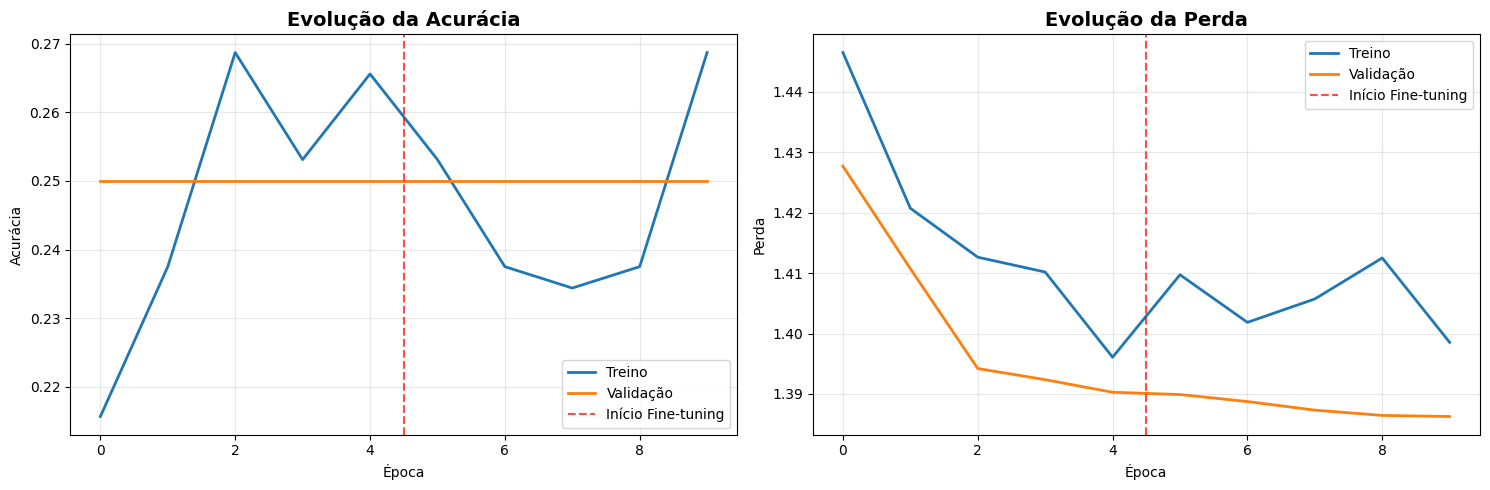

In [ ]:
def plotar_historico_treinamento(historico, historico_ajuste=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    if historico_ajuste:
        acuracia = historico.history['accuracy'] + historico_ajuste.history['accuracy']
        acuracia_val = historico.history['val_accuracy'] + historico_ajuste.history['val_accuracy']
        perda = historico.history['loss'] + historico_ajuste.history['loss']
        perda_val = historico.history['val_loss'] + historico_ajuste.history['val_loss']
        fine_tuning_inicio = len(historico.history['loss'])
    else:
        acuracia = historico.history['accuracy']
        acuracia_val = historico.history['val_accuracy']
        perda = historico.history['loss']
        perda_val = historico.history['val_loss']
        fine_tuning_inicio = None

    ax1.plot(acuracia, label='Treino', linewidth=2)
    ax1.plot(acuracia_val, label='Validação', linewidth=2)
    ax1.set_title('Evolução da Acurácia', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Época')
    ax1.set_ylabel('Acurácia')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    if fine_tuning_inicio:
        ax1.axvline(x=fine_tuning_inicio-0.5, color='red', linestyle='--',
                   label='Início Fine-tuning', alpha=0.7)
        ax1.legend()

    ax2.plot(perda, label='Treino', linewidth=2)
    ax2.plot(perda_val, label='Validação', linewidth=2)
    ax2.set_title('Evolução da Perda', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Época')
    ax2.set_ylabel('Perda')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    if fine_tuning_inicio:
        ax2.axvline(x=fine_tuning_inicio-0.5, color='red', linestyle='--',
                   label='Início Fine-tuning', alpha=0.7)
        ax2.legend()

    plt.tight_layout()
    plt.savefig('historico_treinamento.png', dpi=150, bbox_inches='tight')
    plt.show()

plotar_historico_treinamento(historico, historico_ajuste)

##Matriz de Confusão e Análise Detalhada
Cria uma matriz de confusão para mostrar como o modelo confunde as diferentes raças e gera um relatório detalhado da performance por classe.

3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step


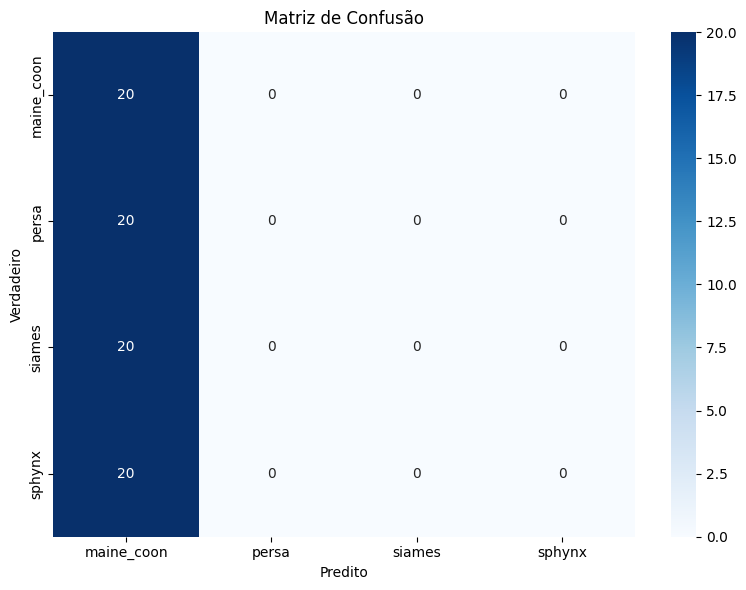

In [ ]:
dados_teste.reset()
predicoes = modelo.predict(dados_teste)
y_previsto = np.argmax(predicoes, axis=1)
y_verdadeiro = dados_teste.classes
matriz_confusao = confusion_matrix(y_verdadeiro, y_previsto)
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusao, annot=True, fmt='d', cmap='Blues',
            xticklabels=RACAS, yticklabels=RACAS)
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.tight_layout()
plt.savefig('matriz_confusao.png')
plt.show()

## **Consumo do modelo**

###Função para Predição
Define uma função que permite usar o modelo treinado para classificar novas imagens de gatos, mostrando a raça prevista e a confiança da predição.

In [21]:
def prever_raca_gato(caminho_imagem, modelo):
    img = tf.keras.preprocessing.image.load_img(caminho_imagem, target_size=TAMANHO_IMG)
    array_img = tf.keras.preprocessing.image.img_to_array(img)
    array_img = np.expand_dims(array_img, axis=0)
    array_img = array_img / 255.0
    predicoes = modelo.predict(array_img)
    indice_classe_prevista = np.argmax(predicoes[0])
    classe_prevista = RACAS[indice_classe_prevista]
    confianca = predicoes[0][indice_classe_prevista]

    print(f"\nPredição para {caminho_imagem}:")
    print(f"Raça: {classe_prevista}")
    print(f"Confiança: {confianca:.2%}")
    print("\nProbabilidades para cada raça:")
    for i, raca in enumerate(RACAS):
        print(f"{raca}: {predicoes[0][i]:.2%}")

    return classe_prevista, confianca

###Relatório de Classificação e Salva o modelo final
Salva o modelo treinado em diferentes formatos para uso posterior, incluindo o modelo completo e apenas os pesos.

In [22]:
print("\nRelatório de Classificação:")
print(classification_report(y_verdadeiro, y_previsto, target_names=RACAS))

modelo.save('classificador_racas_gatos_final.h5')
print("\nModelo salvo como 'classificador_racas_gatos_final.h5'")

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Relatório de Classificação:
              precision    recall  f1-score   support

  maine_coon       0.25      1.00      0.40        20
       persa       0.00      0.00      0.00        20
      siames       0.00      0.00      0.00        20
      sphynx       0.00      0.00      0.00        20

    accuracy                           0.25        80
   macro avg       0.06      0.25      0.10        80
weighted avg       0.06      0.25      0.10        80


Modelo salvo como 'classificador_racas_gatos_final.h5'


# Consumo do modelo em si

Aqui há realmente o consumo do modelo, em que tivemos que carregar o modelo depois que o salvamos e tivemos que também carregar uma imagem no google colab para que pudéssemos prevê-la


In [27]:
modelo = load_model('classificador_racas_gatos_final.h5')
prever_raca_gato('/content/sphynx3.jpg',modelo)

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step

Predição para /content/sphynx3.jpg:
Raça: siames
Confiança: 26.54%

Probabilidades para cada raça:
maine_coon: 24.15%
persa: 24.41%
siames: 26.54%
sphynx: 24.90%


('siames', np.float32(0.2654399))

# **Referências**


Gutierrez, L. M. Projeto Gatos. 2024. Repositório GitHub. Disponível em: https://github.com/LeticiaMoraesG/Projeto_gatos/tree/main. Acesso em: 20 mai. 2025.
KERAS. EfficientNet. In: Keras Applications Documentation. Disponível em: https://keras.io/api/applications/efficientnet/. Acesso em: 27 mai. 2025.
TAN, M. et al. EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks. arXiv preprint arXiv:1905.11946, 2019. Disponível em: https://arxiv.org/abs/1905.11946. Acesso em: 28 mai. 2025.
TENSORFLOW. TensorFlow: An end-to-end open source machine learning platform. Disponível em: https://www.tensorflow.org/. Acesso em: 27 mai. 2025.
de Oliveira, R. IA_TF_MNIST_Classifier.ipynb. Google Colab, 2025. Disponível em: https://colab.research.google.com/github/Rogerio-mack/IA_2025S1/blob/main/AI_TF_MNIST_Classifier.ipynb. Acesso em: 17 maio. 2025.
de Oliveira, R. AI_TF_ImageClassifier.ipynb. Google Colab, 2025. Disponível em: https://colab.research.google.com/github/Rogerio-mack/IA_2025S1/blob/main/AI_TF_ImageClassifier.ipynb. Acesso em: 17 maio. 2025

---

In [ ]:
#@title **Avaliação**
GitHub = 10 #@param {type:"slider", min:0, max:10, step:1}

Implementacao_Model_Code = 7 #@param {type:"slider", min:0, max:10, step:1}

Aplicacao_Streamlit = 9 #@param {type:"slider", min:0, max:10, step:1}

Texto_Artigo  = 6 #@param {type:"slider", min:0, max:10, step:1}

Video = 7 #@param {type:"slider", min:0, max:10, step:1}

Geral = 7 #@param {type:"slider", min:0, max:10, step:1}

In [ ]:
#@title **Nota Final**

nota = 2*GitHub + 4*Implementacao_Model_Code + 2*Aplicacao_Streamlit + 1*Texto_Artigo + 1*Video

nota = nota / 10

print(f'Nota final do trabalho {nota :.1f}')

import numpy as np
import pandas as pd

alunos = pd.DataFrame()

lista_tia = []
lista_nome = []

for i in range(1,6):
  exec("if Aluno" + str(i) + " !='None':  lista = Aluno" + str(i) + ".split(','); lista_tia.append(lista[0]); lista_nome.append(lista[1].upper())")

alunos['tia'] = lista_tia
alunos['nome'] = lista_nome
alunos['nota'] = np.round(nota,1)
print()
display(alunos)

Nota final do trabalho 7.9



,tia,nome,nota
0,1115665,ADRIANA FUJITA,7.9
1,1115677,DANIEL HENRIQUE,7.9
